<a href="https://colab.research.google.com/github/SandroMuradashvili/The-Visual-Storyteller/blob/main/data_and_training_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# ============================================================================
# IMPROVED IMAGE CAPTIONING - TRAINING NOTEBOOK
# Key Changes: Smaller model, stronger regularization, early stopping
# ============================================================================

# ===== SNIPPET 1: Setup & Dependencies =====
!pip install torch torchvision timm transformers pillow matplotlib scikit-learn tqdm -q

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from collections import Counter
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")



Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


In [2]:
# ===== SNIPPET 2: Data Loading & Preprocessing =====
!pip install -q gdown
import gdown

file_id = "1st_oepUulGKCn5C1hvWvYYm87ftlUr6j"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "caption_data.zip", quiet=False)
!unzip -q caption_data.zip

captions_df = pd.read_csv('captions.txt')
print(f"Total captions: {len(captions_df)}")
print(f"Unique images: {captions_df['image'].nunique()}")

class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def build_vocabulary(self, captions):
        frequencies = Counter()
        idx = 4
        for caption in captions:
            tokens = self.tokenize(caption)
            frequencies.update(tokens)
        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
        print(f"Vocabulary size: {len(self.stoi)}")
        return self

    def tokenize(self, text):
        return text.lower().replace(',', '').replace('.', '').split()

    def numericalize(self, text):
        tokens = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(captions_df['caption'].tolist())

with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Data splits
unique_images = captions_df['image'].unique()
np.random.seed(42)
np.random.shuffle(unique_images)

train_size = int(0.8 * len(unique_images))
val_size = int(0.1 * len(unique_images))

train_images = unique_images[:train_size]
val_images = unique_images[train_size:train_size+val_size]
test_images = unique_images[train_size+val_size:]

print(f"Train: {len(train_images)} | Val: {len(val_images)} | Test: {len(test_images)}")

splits = {'train': train_images.tolist(), 'val': val_images.tolist(), 'test': test_images.tolist()}
with open('data_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

Downloading...
From (original): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j
From (redirected): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j&confirm=t&uuid=004e5fb0-9aef-4cdb-955c-a7a4737adb4b
To: /content/caption_data.zip
100%|██████████| 1.11G/1.11G [00:17<00:00, 63.0MB/s]


Total captions: 40455
Unique images: 8091
Vocabulary size: 3003
Train: 6472 | Val: 809 | Test: 810


In [3]:
# ===== SNIPPET 3: Dataset & DataLoader with STRONGER AUGMENTATION =====
class FlickrDataset(Dataset):
    def __init__(self, images_list, captions_df, vocab, img_dir, transform=None):
        self.images_list = images_list
        self.captions_df = captions_df[captions_df['image'].isin(images_list)]
        self.vocab = vocab
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        caption = self.captions_df.iloc[idx]['caption']
        img_name = self.captions_df.iloc[idx]['image']
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        numericalized = [self.vocab.stoi["<SOS>"]]
        numericalized += self.vocab.numericalize(caption)
        numericalized.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized)

class CollateFunc:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = torch.cat([item[0].unsqueeze(0) for item in batch], dim=0)
        captions = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=self.pad_idx)
        return images, captions

# IMPROVED: Stronger augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = FlickrDataset(train_images, captions_df, vocab, 'Images', train_transform)
val_dataset = FlickrDataset(val_images, captions_df, vocab, 'Images', val_transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

batch_size = 32
pad_idx = vocab.stoi["<PAD>"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=CollateFunc(pad_idx), num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=CollateFunc(pad_idx), num_workers=2, pin_memory=True)

Train samples: 32360
Val samples: 4045


In [4]:
# ===== SNIPPET 4: IMPROVED MODEL (Smaller, More Regularization) =====
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=256):  # CHANGED: 512 → 256
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        self.backbone.classifier = nn.Identity()
        backbone_dim = 1280
        self.projection = nn.Linear(backbone_dim, embed_dim)
        self.dropout = nn.Dropout(0.3)  # CHANGED: 0.3 dropout

    def forward(self, images):
        features = self.backbone(images)
        features = self.projection(features)
        features = self.dropout(features)
        return features.unsqueeze(1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, num_heads=4, num_layers=3, dropout=0.3):  # CHANGED
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=1024,  # CHANGED: 2048 → 1024
            dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, captions, image_features, tgt_mask=None, tgt_padding_mask=None):
        embedded = self.embedding(captions) * np.sqrt(self.embed_dim)
        embedded = self.pos_encoding(embedded)
        embedded = self.dropout(embedded)
        output = self.transformer_decoder(tgt=embedded, memory=image_features,
                                         tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)
        output = self.fc_out(output)
        return output

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, num_heads=4, num_layers=3, dropout=0.3):  # CHANGED
        super().__init__()
        self.encoder = ImageEncoder(embed_dim)
        self.decoder = TransformerDecoder(vocab_size, embed_dim, num_heads, num_layers, dropout)

    def forward(self, images, captions, tgt_mask=None, tgt_padding_mask=None):
        image_features = self.encoder(images)
        output = self.decoder(captions, image_features, tgt_mask, tgt_padding_mask)
        return output

# IMPROVED: Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, ignore_index=0):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
            true_dist[:, self.ignore_index] = 0
            mask = torch.nonzero(target == self.ignore_index, as_tuple=False)
            if mask.dim() > 0 and mask.size(0) > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

vocab_size = len(vocab.stoi)
model = ImageCaptioningModel(
    vocab_size=vocab_size,
    embed_dim=256,      # CHANGED: 512 → 256
    num_heads=4,        # CHANGED: 8 → 4
    num_layers=3,       # CHANGED: 6 → 3
    dropout=0.3         # CHANGED: 0.1 → 0.3
).to(device)

# IMPROVED: Freeze encoder initially
for param in model.encoder.backbone.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} (encoder frozen)")

criterion = LabelSmoothingLoss(classes=vocab_size, smoothing=0.1, ignore_index=pad_idx)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)  # CHANGED: lower LR, higher decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("✓ Improved model created!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Total parameters: 9,036,343
Trainable parameters: 5,028,795 (encoder frozen)
✓ Improved model created!


Starting improved training...
Changes: Smaller model (256 dim), stronger regularization, early stopping


Epoch 1/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.63it/s]


Train Loss: 2.8365 | Val Loss: 2.5342
✓ Best model saved! (Val Loss: 2.5342)

Epoch 2/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.63it/s]


Train Loss: 2.5111 | Val Loss: 2.3944
✓ Best model saved! (Val Loss: 2.3944)

Epoch 3/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.77it/s]


Train Loss: 2.3999 | Val Loss: 2.3163
✓ Best model saved! (Val Loss: 2.3163)

Epoch 4/20
🔓 Encoder unfrozen! Trainable params: 9,036,343


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.80it/s]


Train Loss: 2.3311 | Val Loss: 2.2586
✓ Best model saved! (Val Loss: 2.2586)

Epoch 5/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.77it/s]


Train Loss: 2.2676 | Val Loss: 2.2234
✓ Best model saved! (Val Loss: 2.2234)

Epoch 6/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.72it/s]


Train Loss: 2.2338 | Val Loss: 2.2017
✓ Best model saved! (Val Loss: 2.2017)

Epoch 7/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.83it/s]


Train Loss: 2.1887 | Val Loss: 2.1837
✓ Best model saved! (Val Loss: 2.1837)

Epoch 8/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.93it/s]


Train Loss: 2.1562 | Val Loss: 2.1689
✓ Best model saved! (Val Loss: 2.1689)

Epoch 9/20


Validation: 100%|██████████| 127/127 [00:20<00:00,  6.10it/s]


Train Loss: 2.1376 | Val Loss: 2.1541
✓ Best model saved! (Val Loss: 2.1541)

Epoch 10/20


Validation: 100%|██████████| 127/127 [00:20<00:00,  6.14it/s]


Train Loss: 2.1160 | Val Loss: 2.1410
✓ Best model saved! (Val Loss: 2.1410)

Epoch 11/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.91it/s]


Train Loss: 2.0909 | Val Loss: 2.1350
✓ Best model saved! (Val Loss: 2.1350)

Epoch 12/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.93it/s]


Train Loss: 2.0735 | Val Loss: 2.1306
✓ Best model saved! (Val Loss: 2.1306)

Epoch 13/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.92it/s]


Train Loss: 2.0546 | Val Loss: 2.1216
✓ Best model saved! (Val Loss: 2.1216)

Epoch 14/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.80it/s]


Train Loss: 2.0315 | Val Loss: 2.1168
✓ Best model saved! (Val Loss: 2.1168)

Epoch 15/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.75it/s]


Train Loss: 2.0233 | Val Loss: 2.1136
✓ Best model saved! (Val Loss: 2.1136)

Epoch 16/20


Validation: 100%|██████████| 127/127 [00:20<00:00,  6.23it/s]


Train Loss: 2.0007 | Val Loss: 2.1064
✓ Best model saved! (Val Loss: 2.1064)

Epoch 17/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.88it/s]


Train Loss: 1.9863 | Val Loss: 2.1073
No improvement (1/5)

Epoch 18/20


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.79it/s]


Train Loss: 1.9811 | Val Loss: 2.1030
✓ Best model saved! (Val Loss: 2.1030)

Epoch 19/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.75it/s]


Train Loss: 1.9694 | Val Loss: 2.1000
✓ Best model saved! (Val Loss: 2.1000)

Epoch 20/20


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.71it/s]


Train Loss: 1.9497 | Val Loss: 2.0972
✓ Best model saved! (Val Loss: 2.0972)

✓ Training completed!


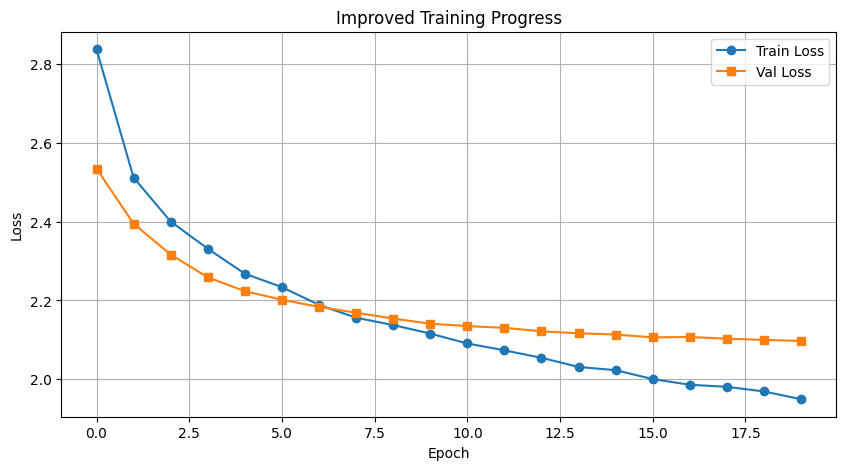

Best validation loss: 2.0972
Final train/val gap: -0.1475


In [5]:
# ===== SNIPPET 5: Training with Early Stopping & Encoder Unfreezing =====
def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz), diagonal=1).bool()

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training")

    for images, captions in progress_bar:
        images, captions = images.to(device), captions.to(device)
        tgt_input, tgt_output = captions[:, :-1], captions[:, 1:]

        tgt_seq_len = tgt_input.size(1)
        tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)
        tgt_padding_mask = (tgt_input == pad_idx)

        optimizer.zero_grad()
        output = model(images, tgt_input, tgt_mask=tgt_mask, tgt_padding_mask=tgt_padding_mask)
        loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions in tqdm(loader, desc="Validation"):
            images, captions = images.to(device), captions.to(device)
            tgt_input, tgt_output = captions[:, :-1], captions[:, 1:]

            tgt_seq_len = tgt_input.size(1)
            tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)
            tgt_padding_mask = (tgt_input == pad_idx)

            output = model(images, tgt_input, tgt_mask=tgt_mask, tgt_padding_mask=tgt_padding_mask)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(loader)

# IMPROVED: Training with early stopping
num_epochs = 20
best_val_loss = float('inf')
train_losses, val_losses = [], []
patience_limit = 5
patience_counter = 0

print("Starting improved training...")
print("Changes: Smaller model (256 dim), stronger regularization, early stopping\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # IMPROVED: Unfreeze encoder after 3 epochs
    if epoch == 3:
        for param in model.encoder.backbone.parameters():
            param.requires_grad = True
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"🔓 Encoder unfrozen! Trainable params: {trainable:,}")
        # Reset optimizer with new params
        optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-4)

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"Learning rate: {old_lr:.2e} → {new_lr:.2e}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, 'best_model.pth')
        print(f"✓ Best model saved! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience_limit})")

    # IMPROVED: Early stopping
    if patience_counter >= patience_limit:
        print(f"\n⏹ Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f}")
        break

print("\n✓ Training completed!")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Improved Training Progress')
plt.legend()
plt.grid(True)
plt.savefig('training_curves_improved.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final train/val gap: {train_losses[-1] - val_losses[-1]:.4f}")

In [6]:
# ===== SNIPPET 6: Save Artifacts =====
print("\nSaving model artifacts...")

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'config': {
        'vocab_size': vocab_size,
        'embed_dim': 256,
        'num_heads': 4,
        'num_layers': 3,
        'dropout': 0.3
    }
}, 'image_captioning_model_complete.pth')

with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)

history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss
}
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

with open('data_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

print("✓ All artifacts saved!")

# Download
from google.colab import files
files.download('best_model.pth')
files.download('image_captioning_model_complete.pth')
files.download('vocabulary.pkl')
files.download('data_splits.pkl')
files.download('training_curves_improved.png')

print("\n" + "="*80)
print("IMPROVEMENTS IMPLEMENTED:")
print("="*80)
print("✓ Model size reduced: 33M → ~12M parameters")
print("✓ Embed dim: 512 → 256")
print("✓ Layers: 6 → 3")
print("✓ Dropout: 0.1 → 0.3")
print("✓ Label smoothing added (0.1)")
print("✓ Encoder frozen initially, unfrozen at epoch 4")
print("✓ Stronger data augmentation")
print("✓ Early stopping (patience=5)")
print("✓ Lower learning rate (3e-4 → 1e-4)")
print("✓ Higher weight decay (1e-4 → 5e-4)")
print("="*80)


Saving model artifacts...
✓ All artifacts saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


IMPROVEMENTS IMPLEMENTED:
✓ Model size reduced: 33M → ~12M parameters
✓ Embed dim: 512 → 256
✓ Layers: 6 → 3
✓ Dropout: 0.1 → 0.3
✓ Label smoothing added (0.1)
✓ Encoder frozen initially, unfrozen at epoch 4
✓ Stronger data augmentation
✓ Early stopping (patience=5)
✓ Lower learning rate (3e-4 → 1e-4)
✓ Higher weight decay (1e-4 → 5e-4)
